In [36]:
# Try to use the GPU if possible
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [37]:
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [38]:
import torch
import torch.nn as nn

lat_v_size = 64
img_size = 28 * 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(img_size, lat_v_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(lat_v_size, img_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x
        
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [39]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
opt = torch.optim.Adam(params_to_optimize, lr=1e-3)

In [40]:
batch_size = 64
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
def test_model(encoder, decoder, loss_fn):
    original_states = encoder.training, decoder.training
    encoder.eval(), decoder.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.reshape((-1, 1, 28*28)).to(device)
            lat_v = encoder(batch)
            out = decoder(lat_v)
            total_loss += loss_fn(out, batch).item()
    encoder.train(original_states[0])
    decoder.train(original_states[1])
    return total_loss / len(test_loader)

In [41]:
from tqdm import tqdm

epochs = 5
loss_fn = torch.nn.MSELoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
train_losses = []
test_losses = [test_model(encoder, decoder, loss_fn)]
log_interv = 100
encoder.train()
decoder.train()
for epoch in range(epochs):
    print(f"Starting epoch {epoch}")
    for i, (batch, _) in enumerate(tqdm(train_loader)):
        batch = batch.reshape((-1, 1, 28*28)).to(device)
        lat_v = encoder(batch)
        out = decoder(lat_v)
        loss = loss_fn(out, batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_losses.append(loss.cpu().detach().numpy())
        if len(train_losses) % log_interv == 0:
            test_losses.append(test_model(encoder, decoder, loss_fn))
test_losses.append(test_model(encoder, decoder, loss_fn))
encoder.eval()
decoder.eval()



Starting epoch 0


100%|██████████| 938/938 [01:40<00:00,  9.35it/s]


Starting epoch 1


100%|██████████| 938/938 [01:30<00:00, 10.37it/s]


Starting epoch 2


100%|██████████| 938/938 [01:40<00:00,  9.34it/s]


Starting epoch 3


100%|██████████| 938/938 [01:31<00:00, 10.28it/s]


Starting epoch 4


100%|██████████| 938/938 [01:32<00:00, 10.17it/s]


Decoder(
  (l1): Linear(in_features=64, out_features=784, bias=True)
)

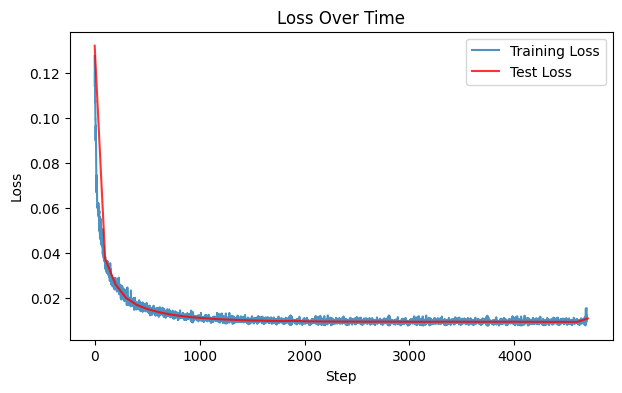

In [42]:
import matplotlib.pyplot as plt

test_steps = [i * log_interv for i in range(len(test_losses))]

plt.figure(figsize=(7, 4))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', alpha=0.8)
plt.plot(test_steps, test_losses, linestyle='-', color='red', label='Test Loss', alpha=0.8)

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()